# Notes

- Predicted score is very close to Kaggle score

In [1]:
# The rest of the modules are loaded when required.
# To ensure a standalone character (for easier reusability).

import os # for detecting CPU cores
import configparser # to load standard config and parameters
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
%load_ext watermark
%matplotlib inline

In [2]:
# Load external config file
config = configparser.ConfigParser()
config.read("../src/config.ini")

PATH_DATA_RAW = config["PATHS"]["PATH_DATA_RAW"]
PATH_DATA_INT = config["PATHS"]["PATH_DATA_INT"]
PATH_DATA_PRO = config["PATHS"]["PATH_DATA_PRO"]
PATH_REPORTS = config["PATHS"]["PATH_REPORTS"]
PATH_MODELS = config["PATHS"]["PATH_MODELS"]
PATH_SUB = config["PATHS"]["PATH_SUB"]

# Telegram Bot
token = config["TELEGRAM"]["token"]
chat_id = config["TELEGRAM"]["chat_id"]
FILENAME_NB = "02_baseline_models" # for Telegram messages

# Set global randome state
rnd_state = 42

# Define available cpu cores
n_cpu = os.cpu_count()
print("Number of CPUs used:", n_cpu)

Number of CPUs used: 16


In [5]:
# INTERIM OPT
train_df = pd.read_pickle(PATH_DATA_INT+'train-opt-fe.pkl')
test_df = pd.read_pickle(PATH_DATA_INT+'test-opt-fe.pkl')
sample_df = pd.read_csv(PATH_DATA_RAW+'sample_submission.csv')

# Memory Usage
train_df.info(memory_usage="deep")
print()
test_df.info(memory_usage="deep")

# Preparing features and target
#features_num = train_df.drop(['id','target'], axis=1).columns
features_num = train_df.drop(['target'], axis=1).columns
feature_cols = features_num.to_list()

#X = train_df.drop(['id','target'], axis=1).copy()
#y = train_df['target'].copy()
#X_test = test_df.drop(['id'], axis=1).copy()

X = train_df.drop(['target'], axis=1).copy()
y = train_df['target'].copy()
X_test = test_df.copy()

X.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Columns: 156 entries, f0 to target
dtypes: float32(155), int8(1)
memory usage: 355.3 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540000 entries, 0 to 539999
Columns: 155 entries, f0 to cluster_poly46
dtypes: float32(155)
memory usage: 319.3 MB


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,cluster_poly37,cluster_poly38,cluster_poly39,cluster_poly40,cluster_poly41,cluster_poly42,cluster_poly43,cluster_poly44,cluster_poly45,cluster_poly46
0,0.023869,0.414343,-0.003178,0.223129,0.219181,-0.549174,0.356604,-0.117173,-0.149785,-0.569723,...,6512.845215,6805.715820,13652.173828,10663.488281,4265.094238,8555.721680,6682.733398,8940.457031,6983.243652,14008.291992
1,0.073411,-0.324111,-0.220699,0.301799,0.406584,0.980651,-0.584290,-1.216782,0.824004,-0.258296,...,4172.796387,4559.007324,11665.178711,8874.093750,2205.772949,5643.933105,4293.529785,6166.304688,4690.915039,12002.692383
2,-0.165673,-0.391725,0.386256,-0.178365,-0.372808,0.210182,0.863859,0.518747,-0.268295,-0.021567,...,3554.209229,3881.383545,10787.007812,8026.498047,1839.628296,5112.631348,3804.254883,5583.262695,4154.446289,11545.894531
3,-0.301555,-0.872802,2.498527,-0.301544,-0.587486,-0.414987,-0.039545,0.787011,0.807039,0.794548,...,4730.939941,5049.254395,12155.591797,9210.494141,2632.450684,6337.370605,4801.931152,6763.771484,5125.021973,12337.995117
4,-0.272393,0.460876,0.086985,-0.197278,-0.465605,-0.192678,0.518429,-1.042825,0.356489,-0.301740,...,3570.980469,3988.572266,11142.793945,8272.177734,1762.070557,4922.661133,3654.481201,5498.319336,4081.837402,11403.347656


In [6]:
# Scaling all values
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# --------------------------------------------------------------------
# MinMaxScaler(feature_range = (0, 1)) will transform each value in the column proportionally within the range [0,1]. 
# Use this as the first scaler choice to transform a feature, as it will preserve the shape of the dataset 
# (no distortion).

# StandardScaler() will transform each value in the column to range about the mean 0 and standard deviation 1, ie, 
# each value will be normalised by subtracting the mean and dividing by standard deviation. Use StandardScaler if 
# you know the data distribution is normal.

# If there are outliers, use RobustScaler(). Alternatively you could remove the outliers and use either of the above 
# 2 scalers (choice depends on whether data is normally distributed)

# Additional Note: If scaler is used before train_test_split, data leakage will happen. 
# Do use scaler after train_test_split
# --------------------------------------------------------------------

scaler = StandardScaler()
#scaler = MinMaxScaler()
#scaler = RobustScaler()

"""
for col in feature_cols:
    X[col] = s_scaler.fit_transform(np.array(X[col]).reshape(-1,1))
    X_test[col] = s_scaler.transform(np.array(X_test[col]).reshape(-1,1))
"""

# train
X_scaled = scaler.fit_transform(X[feature_cols])
X = pd.DataFrame(X_scaled, columns=feature_cols, index=X.index)

# test
X_test_scaled = scaler.transform(X_test[feature_cols])
X_test = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)


In [7]:
X.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,cluster_poly37,cluster_poly38,cluster_poly39,cluster_poly40,cluster_poly41,cluster_poly42,cluster_poly43,cluster_poly44,cluster_poly45,cluster_poly46
0,-0.382553,0.705772,-0.315075,0.347277,-0.229657,-0.875660,0.660314,-0.197064,-0.286162,-0.289270,...,1.068591,1.013719,1.042430,1.026898,0.935574,1.242489,1.153755,1.174762,1.095656,1.121353
1,-0.347377,-0.530387,-0.417062,0.472862,-0.187909,1.623543,-0.910506,-1.963980,1.309644,-0.229122,...,-0.090666,-0.112540,-0.069231,0.003631,-0.139317,-0.126337,-0.090038,-0.160769,-0.114093,-0.072476
2,-0.517136,-0.643571,-0.132486,-0.293650,-0.361533,0.364863,1.507175,0.824771,-0.480372,-0.183401,...,-0.397113,-0.452229,-0.560540,-0.481067,-0.330431,-0.376101,-0.344750,-0.441457,-0.397208,-0.344384
3,-0.613619,-1.448884,0.857867,-0.490286,-0.409357,-0.656445,-0.001055,1.255833,1.281843,-0.025780,...,0.185838,0.133217,0.205140,0.196002,0.083393,0.199646,0.174630,0.126863,0.115002,0.127113
4,-0.592913,0.783666,-0.272802,-0.323841,-0.382205,-0.293270,0.930480,-1.684456,0.543499,-0.237512,...,-0.388805,-0.398496,-0.361489,-0.340575,-0.370914,-0.465406,-0.422720,-0.482350,-0.435526,-0.429234


In [8]:
scaler = RobustScaler()
train = scaler.fit_transform(X)
test = scaler.transform(X_test)
target = y

## Model and training

In [9]:
import gc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.backend import clear_session
from sklearn.model_selection import StratifiedKFold, train_test_split

In [10]:
def create_model_cnn(units, dim, optimizer, kernel_initializer):
    model = Sequential()
    model.add(Conv1D(units, 2, activation="swish", input_shape=(dim,1)))
    model.add(MaxPooling1D())
    model.add(BatchNormalization())
    model.add(Conv1D(units, 2, activation="swish", input_shape=(dim,1)))
    model.add(MaxPooling1D())
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(units, activation="relu"))
    model.add(Dense(units = 1, activation = 'sigmoid'))
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['AUC'])    
    return model    


In [11]:
def create_model(units, dim, optimizer, kernel_initializer):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units = units, activation = 'swish', input_dim = dim))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(units = units, activation = 'swish'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(units = units, activation = 'swish'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(units = units, activation = 'swish'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(units = units, activation = 'swish'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(units = units, activation = 'swish'))
    model.add(keras.layers.Dense(units = 1, activation = 'sigmoid'))
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['AUC'])
    return model    

lr = ReduceLROnPlateau(monitor="val_auc", factor=0.5, patience=5, verbose=1)
es = EarlyStopping(monitor="val_auc", patience=60, verbose=1, mode="min", restore_best_weights=True)

In [12]:
UNITS = 32
EPOCHS = 40
BATCH_SIZE = 256
TOTAL_SPLITS = 4
LEARNING_RATE = 0.00123
CNN = False


if CNN:
    train = train.reshape(train.shape[0], train.shape[1], 1)
    test = test.reshape(test.shape[0], test.shape[1], 1)


models = []
histories = []
folds = StratifiedKFold(n_splits=TOTAL_SPLITS, shuffle=True, random_state=rnd_state)

for fold_n, (train_index, valid_index) in enumerate(folds.split(train, target)):
    clear_session()
    gc.collect()
    print('-'*15, '>', f'Fold {fold_n}', '<', '-'*15)
    X_train, X_valid = train[train_index], train[valid_index]
    y_train, y_valid = target[train_index], target[valid_index]    
    
    if CNN:
        model = create_model_cnn(UNITS, train.shape[1], keras.optimizers.Adam(learning_rate=LEARNING_RATE), 'glorot_uniform')
    else:
        model = create_model(UNITS, train.shape[1], keras.optimizers.Adam(learning_rate=LEARNING_RATE), 'glorot_uniform')

    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size = BATCH_SIZE, epochs = EPOCHS, 
                    verbose=1, shuffle=True, callbacks=[lr, es])
    models.append(model)
    histories.append(history)

--------------- > Fold 0 < ---------------
Epoch 1/40
1758/1758 [==============================] - 8s 4ms/step - loss: 0.6056 - auc: 0.7292 - val_loss: 0.5759 - val_auc: 0.7456 - lr: 0.0012
Epoch 2/40
1758/1758 [==============================] - 7s 4ms/step - loss: 0.5777 - auc: 0.7453 - val_loss: 0.5737 - val_auc: 0.7456 - lr: 0.0012
Epoch 3/40
1758/1758 [==============================] - 7s 4ms/step - loss: 0.5745 - auc: 0.7470 - val_loss: 0.5755 - val_auc: 0.7436 - lr: 0.0012
Epoch 4/40
1758/1758 [==============================] - 7s 4ms/step - loss: 0.5731 - auc: 0.7477 - val_loss: 0.5736 - val_auc: 0.7451 - lr: 0.0012
Epoch 5/40
1758/1758 [==============================] - 7s 4ms/step - loss: 0.5724 - auc: 0.7480 - val_loss: 0.5731 - val_auc: 0.7461 - lr: 0.0012
Epoch 6/40
1758/1758 [==============================] - 7s 4ms/step - loss: 0.5717 - auc: 0.7480 - val_loss: 0.5760 - val_auc: 0.7443 - lr: 0.0012
Epoch 7/40
1758/1758 [==============================] - 7s 4ms/step - loss:

## Plotting metrics recorded during training

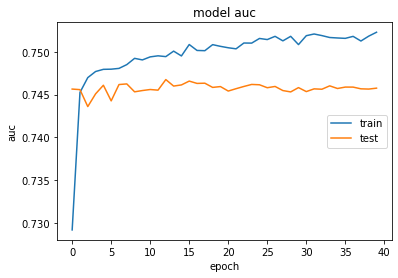

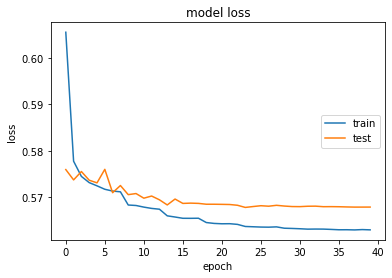

In [13]:
import matplotlib.pyplot as plt

# summarize history for accuracy
history = histories[0]
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='center right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='center right')
plt.show()

In [15]:
import numpy as np
np.max(history.history['val_auc'])

0.7467543482780457

## Prediction

In [16]:
import numpy as np

predicted = []
for model in models:
    predicted.append(model.predict(test))

avg_preds = np.zeros(len(predicted[0]))
for pred in predicted:
    avg_preds += pred.ravel()
avg_pred = avg_preds / len(models)

In [17]:
sample_df['target'] = avg_pred
sample_df['id'] = sample_df['id'].astype(int)
sample_df.to_csv('submission.csv', index=False, float_format='%.6f')
sample_df.head(5)

,id,target
0,600000,0.741833
1,600001,0.740295
2,600002,0.744158
3,600003,0.246080
4,600004,0.739952


In [18]:
sample_df.dtypes

id          int32
target    float64
dtype: object

- train-opt: VAL AUC: 0.7473278641700745 | Kaggle: 0.74735
- train-opt-fe: 0.7467543482780457

In [19]:
#!kaggle competitions submit tabular-playground-series-nov-2021 -f submission.csv -m ''